# Sheet 6

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

# 1) Top tagging with CNNs

In [14]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
# import os, sys
# import wget
# from zipfile import ZipFile
# from tqdm import tqdm

# DESTINATION = "data06"
# url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
# filename = "toptagging-short.zip"
# url = url + filename

# os.makedirs(DESTINATION, exist_ok=True)
# os.chdir(DESTINATION)
# wget.download(url, filename)
# with ZipFile(filename, "r") as zip_ref:
#     for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
#         zip_ref.extract(member=file)
# os.chdir("..")
# %ls data06

In [3]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

# shape: (events, particles, 4-momenta)
# 4-momenta are ordered as (E, px, py, pz)
# y are the labels (1 for signal=top jet, 0 for background=QCD jet)
print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


### (a)

#### Initial settings (Preprocessing)

In [4]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

#### Create Images

In [5]:
# needs roughly 3GB of RAM in orig_image
# reduce the number of events in the dataset if needed
z_train = constit_to_img( X_train, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


#### Display training data

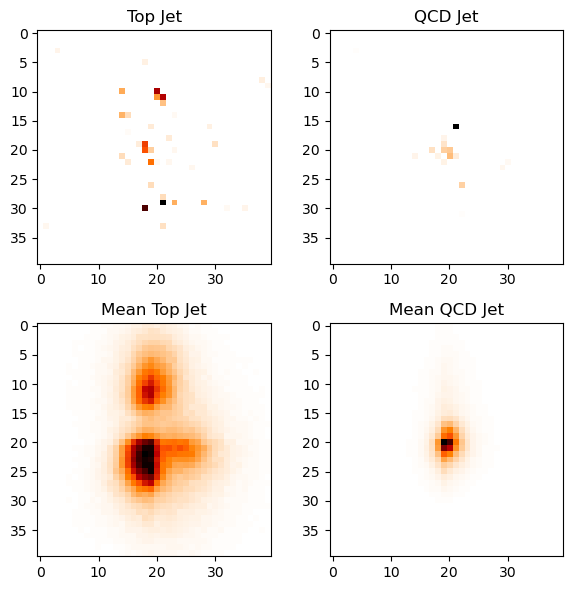

In [6]:
# figure with two subplots that are imshows
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].imshow(z_train[y_train == 1][0, 0], cmap="gist_heat_r")
ax[0, 0].set_title("Top Jet")
ax[0, 1].imshow(z_train[y_train == 0][0, 0], cmap="gist_heat_r")
ax[0, 1].set_title("QCD Jet")
ax[1, 0].imshow(np.mean(z_train[y_train == 1].squeeze(), axis=0), cmap="gist_heat_r")
ax[1, 0].set_title("Mean Top Jet")
ax[1, 1].imshow(np.mean(z_train[y_train == 0].squeeze(), axis=0), cmap="gist_heat_r")
ax[1, 1].set_title("Mean QCD Jet")

# add more space between plots
plt.tight_layout()

plt.show()

In [93]:
z_train[0, 0].min()

0.0

### (b)

In [7]:
# TODO: Implement your own BCE loss
def my_BCELoss(scores, labels):
    # scores are the predictions
    # labels are the true labels
    assert scores.shape == labels.shape
    return -torch.mean(labels*torch.log(scores) + (1-labels)*torch.log(1-scores))

In [8]:
# Create some random test data
y_pred = torch.rand(10, requires_grad=True)
y_true = torch.randint(0, 2, (10,)).float()

# Compute the loss with your custom function
custom_loss = my_BCELoss(y_pred, y_true)

# Compute the loss with PyTorch's function
torch_loss = nn.BCELoss()(y_pred, y_true)

# Check if the losses are close
assert np.isclose(custom_loss.item(), torch_loss.item(), atol=1e-6), "The losses are not close"

print("The losses are close")
del y_pred, y_true, custom_loss, torch_loss


The losses are close


### (c)

- two conv layers
- max pooling
- one linear layer
- track validation loss

In [72]:
# TODO: Implement and train CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.main = nn.Sequential(
            # add keywords to the following line
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # gives 3 channels of size 20x20
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # gives 3 channels of size 10x10
            nn.Dropout2d(0.2),
            nn.Flatten(),
            nn.Linear(3200, 1),  # 3200 = 32 (channels) * 10 * 10 
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.main(x)

In [73]:
# dataset
class Jet_Dataset(torch.utils.data.Dataset):
    # no preprocessing needed (i.e. no unsqueeze) to get layers dim
    def __init__(self, data, labels):
        self.data = torch.tensor(data).to(torch.float32)
        self.labels = torch.tensor(labels).to(torch.float32)
        self.length = len(data)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [74]:
# dataloaders
trn_dataloader = torch.utils.data.DataLoader(Jet_Dataset(z_train, y_train), batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(Jet_Dataset(z_val, y_val), batch_size=64, shuffle=False)

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [76]:
def batch_loss(model, x, y, loss_fn):
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    return loss_fn(y_pred.flatten(), y)

In [77]:
def train_epoch(model, dataloader, losses, batch_loss_fn, loss_fn, optimizer):
    # run for each epoch (and ran over all data)
    for x, y in dataloader:
        # loading in batches of batchsize
        optimizer.zero_grad()
        loss = batch_loss_fn(model, x, y, loss_fn)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [78]:
model = CNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
validation_losses = []
for epoch in tqdm(range(10)):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss, loss_fn, optimizer)
    validation_losses.append(
        np.mean([batch_loss(model, x, y, loss_fn).detach().numpy() for x, y in val_dataloader])
    )

100%|██████████| 10/10 [04:37<00:00, 27.75s/it]


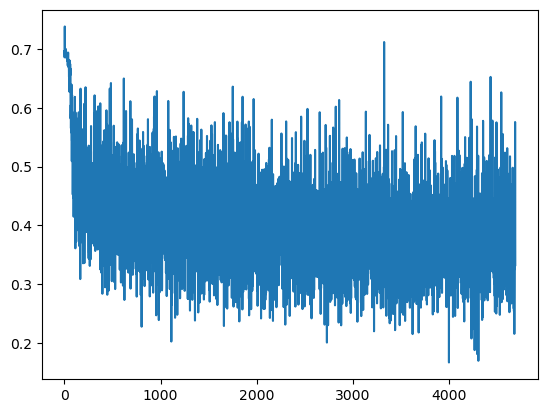

In [79]:
plt.plot(train_losses)

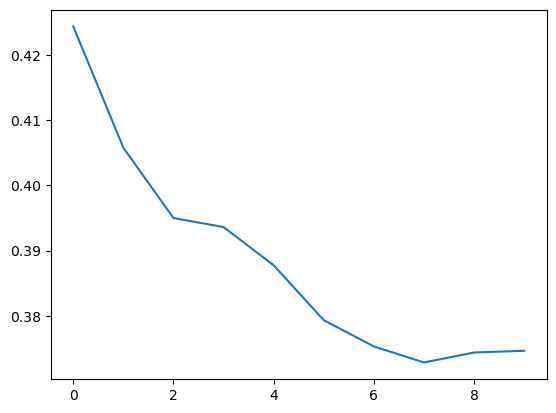

In [81]:
plt.plot(validation_losses)

### (d)

In [82]:
from sklearn.metrics import roc_curve, roc_auc_score

# TODO: Compute tpr, fpr, auc_score

In [94]:
# TODO: Evaluate classifier
y_pred = model(torch.tensor(z_test).to(device).to(torch.float32)).detach().cpu().numpy().flatten()

In [95]:
# calculate TPR and FPR using sklearn
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

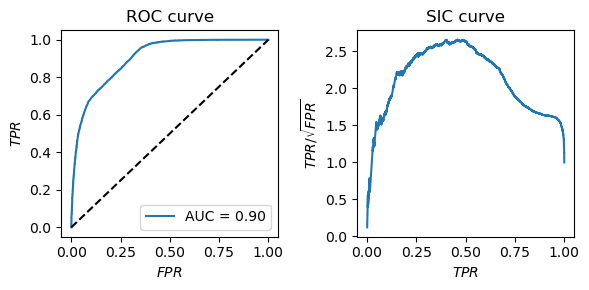

In [116]:
from sklearn.metrics import roc_auc_score

# Assuming y_true is your ground truth labels and y_score is the predicted probabilities
auc_score = roc_auc_score(y_test, y_pred)

# create figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# plot ROC curve
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot([0, 1], [0, 1], "--", color="black")
ax[0].set_title("ROC curve")
ax[0].set_xlabel("$FPR$")
ax[0].set_ylabel("$TPR$")
ax[0].legend(loc='lower right')

# plot SIC curve
ax[1].plot(tpr[fpr != 0], tpr[fpr != 0]/np.sqrt(fpr[fpr != 0]))
ax[1].set_title("SIC curve")
ax[1].set_xlabel("$TPR$")
ax[1].set_ylabel("$TPR/\sqrt{{FPR}}$")

plt.tight_layout()
plt.show()

# 2) Implementing Transformers with a Transformer

In [4]:
# TODO: Ask chatGPT for multi-headed self-attention